<!-- # Adversarial Action Recognition Attack -->
# Fast Sign Gradient Method on melanoma detection apps

This notebook demonstrates how to use the ART library to conduct an adversarial attack using FSGM on melanoma detection apps.

---

We can find lots of apps in the marketplaces where they claim to be effective in detecting melanomas from a pic using deep learning. In this notebook, we are going to test their robustness in adversarial scenarios, and how to make a black-box adversarial attack using FSGM neither knowing their neural network architecture or how they were trained on which dataset. This could be performed taking advantage of [transferability](https://arxiv.org/pdf/1605.07277.pdf), a property where some adversarial examples produced to mislead a specific model f can mislead other models f', even if their architectures greatly differ.

## STEP 1
Imports and define some helpful fuctions and variables.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import (
    load_img, 
    img_to_array, 
    array_to_img
)

from art import config
from art.utils import get_file
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import TensorFlowV2Classifier

from keras.applications.mobilenet_v2 import preprocess_input

In [2]:
def decode_image(image):
    image = load_img(image, target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1], 3))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    return image

In [3]:
INPUT_SHAPE = [512, 512]

## STEP 2
We don't know anything about how a melanoma app works in their core. We just know that it allows us to upload a pic and it says to us wether is a melanoma or not.
So we create our own model, assuming that it's highly probably that they used a similar architecture, and [transfer learning](https://ftp.cs.wisc.edu/machine-learning/shavlik-group/torrey.handbook09.pdf) from imagenet

In [4]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(INPUT_SHAPE[0],
                                                            INPUT_SHAPE[1],
                                                            3),
                                               include_top=False,
                                               weights = "imagenet")
base_model.trainable = False

In [5]:
model = tf.keras.Sequential([base_model,
                             tf.keras.layers.GlobalAveragePooling2D(),
                             tf.keras.layers.Dense(20, activation = "relu"),
                             tf.keras.layers.Dropout(0.4),
                             tf.keras.layers.Dense(10, activation = "relu"),
                             tf.keras.layers.Dropout(0.3),
                             tf.keras.layers.Dense(1, activation = "sigmoid")
                             ])

We are not going to train this network, but you could do and train your network if needed. There are a lot of datasets about this topic that you can find in [Google Datasets](https://datasetsearch.research.google.com/search?query=Melanoma%20Detection%20Dataset&docid=L2cvMTFqbl9mcDhqNQ%3D%3D).
We won't train this network, but you could do and train your network if needed. There are a lot of datasets about this topic that you can find in Google Datasets.
In this notebook, we are going to load weights from a network that I've already trained.

In [6]:
path_weights = get_file('weights.h5', extract=False, path=config.ART_DATA_PATH,
                        url='https://github.com/FranSPG/melanomas_attacks_ART/raw/main/model_weights/weights.h5')

In [7]:
model.load_weights(path_weights)

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 16, 16, 1280)      2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 20)                25620     
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1

## STEP 3
Let's take a look at some applications on an Android device and see how it works.

In [9]:
img_path = get_file('Melanoma3.png', extract=False, path=config.ART_DATA_PATH,
                    url='https://github.com/FranSPG/melanomas_attacks_ART/raw/main/melanoma_images/Melanoma3.png')

# img_path = get_file('melanoma2.jpeg', extract=False, path=config.ART_DATA_PATH,
#                     url='https://github.com/FranSPG/melanomas_attacks_ART/raw/main/melanoma_images/melanoma2.jpeg')

In [10]:
test_img = decode_image(img_path)

Here, we can see a pic corresponding to melanoma.

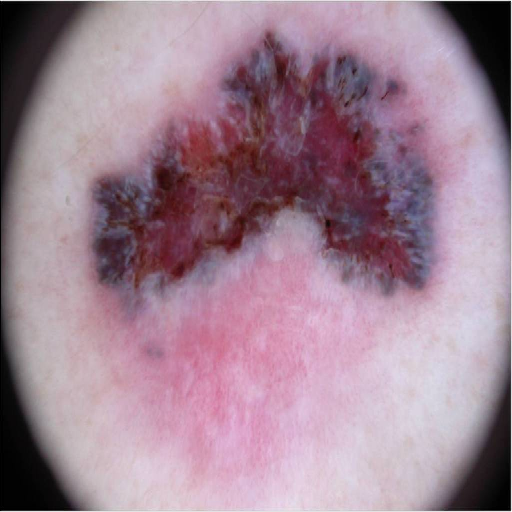

In [11]:
array_to_img(test_img[0])

Let's give this image to the app and see what it says about.

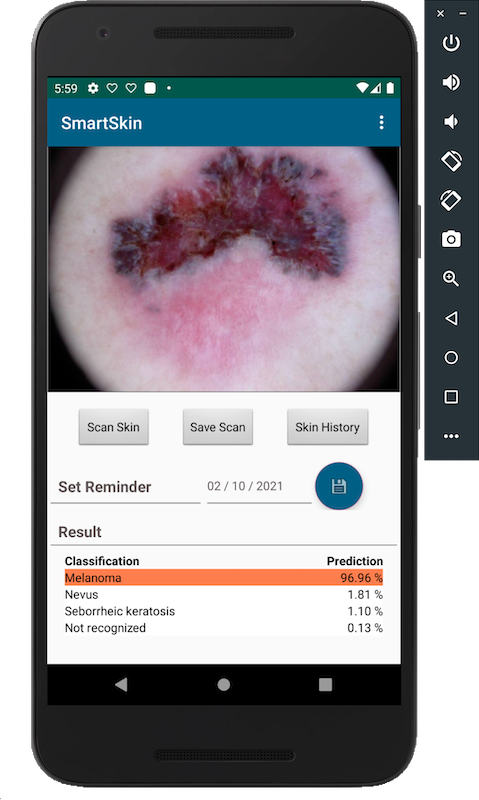

Ass we can see, the app is very confident about this pic being a melanoma.\
Now let's see what's happen when we use FSGM to create an adversarial.

In [12]:
model_art = TensorFlowV2Classifier(
    model=model,
    loss_object=tf.keras.losses.BinaryCrossentropy(),
    nb_classes=1,
    input_shape=(INPUT_SHAPE[0], INPUT_SHAPE[1], 3)
)

In [13]:
fsg = FastGradientMethod(
    model_art,
    eps=0.185,
)

In [14]:
x_test_adv = fsg.generate(x=test_img)

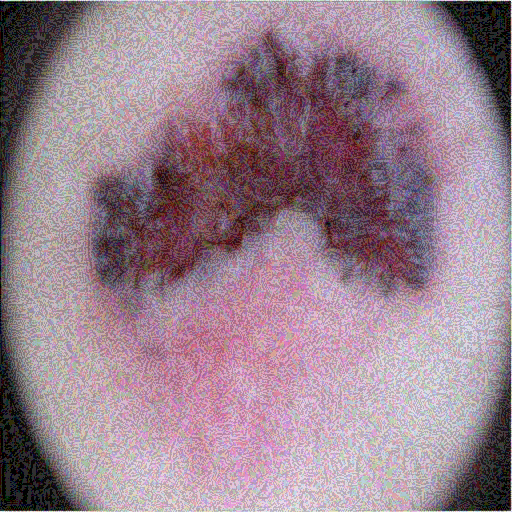

In [15]:
array_to_img(x_test_adv[0])

In [16]:
# Save your adversarial image using this
# array_to_img(x_test_adv[0]).save('YOUR PATH HERE')

Now, let's give the new adversarial image to the app and see its prediction.

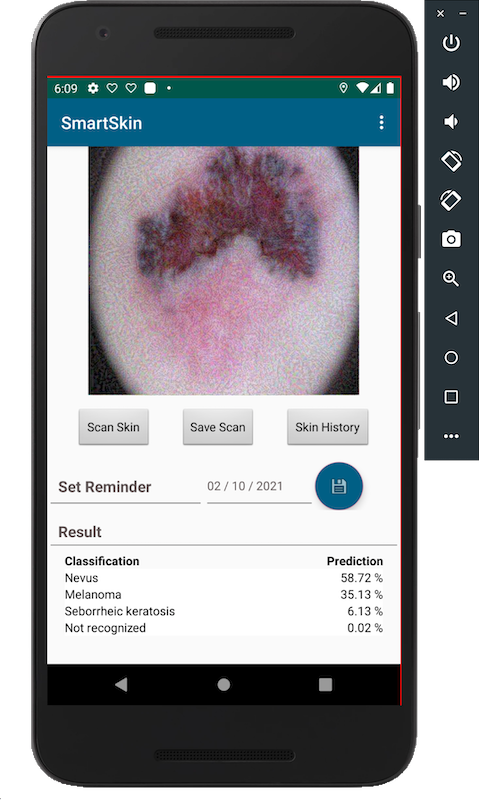

Effectively, we can see that the prediction is messed up.

And we can try this in several different apps getting the same result.

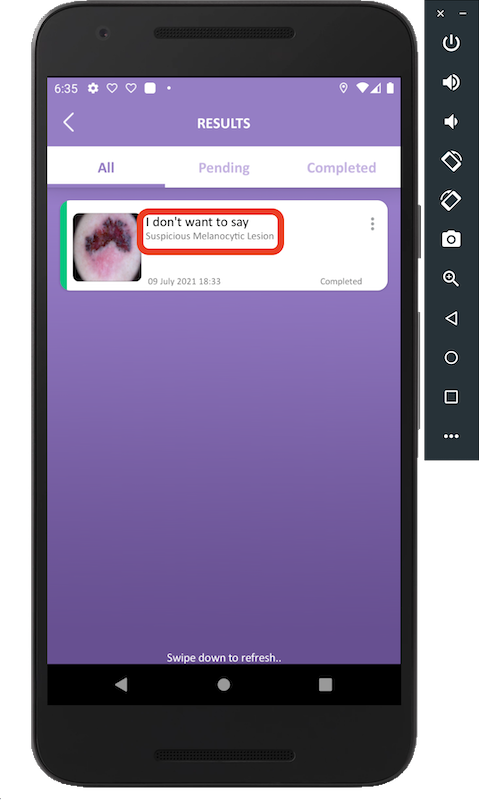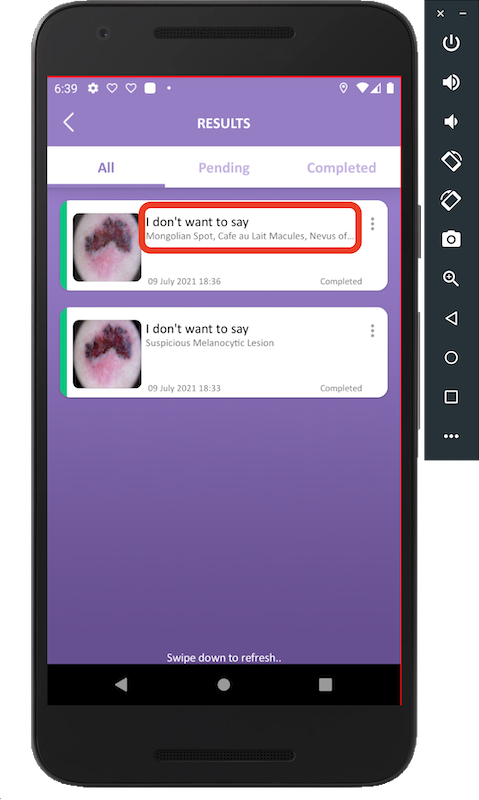

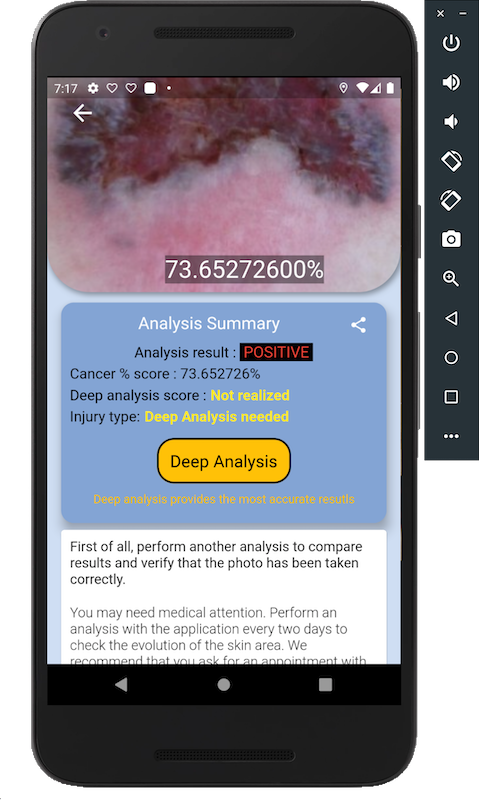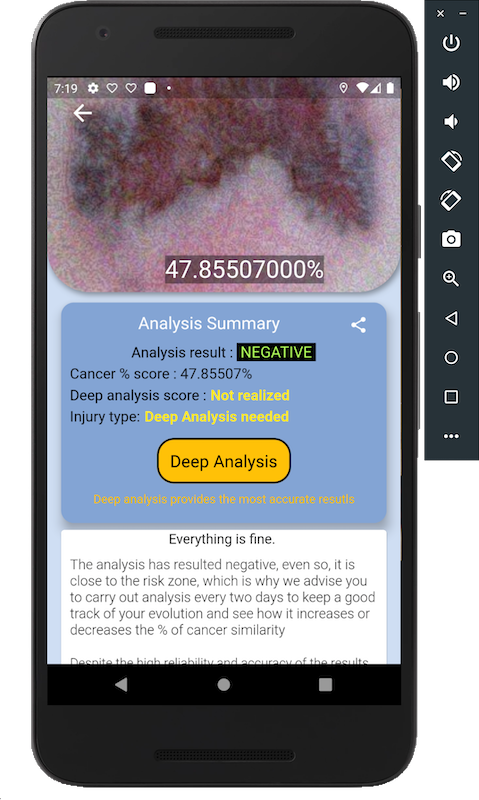

Same process with different image

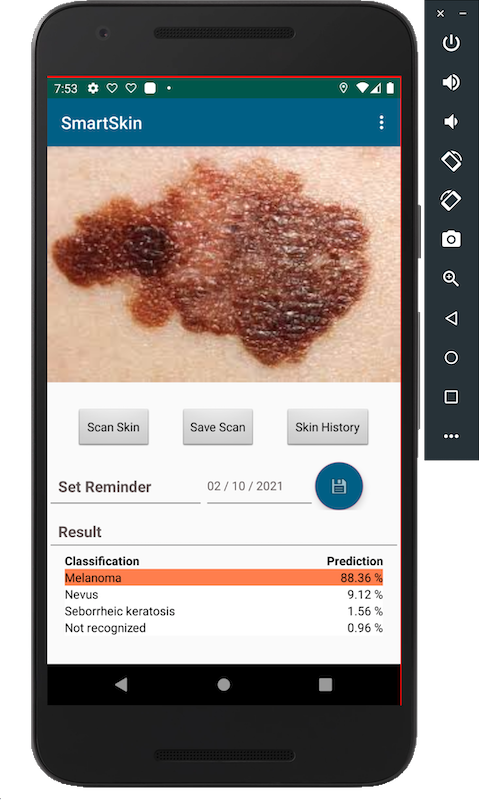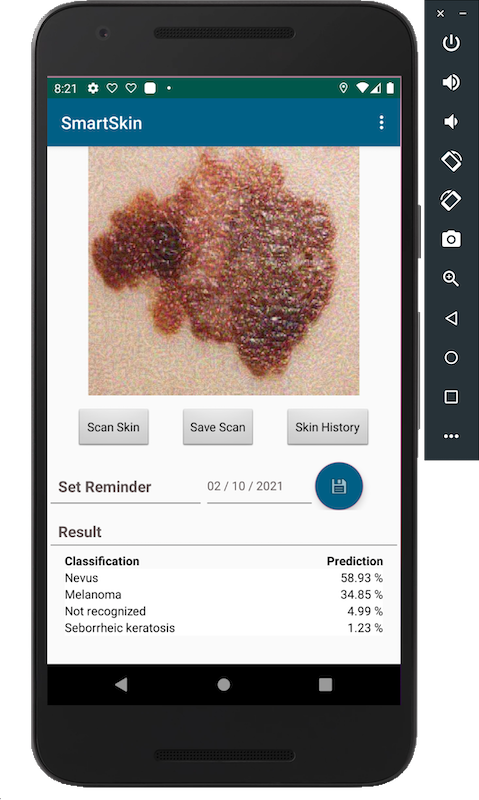

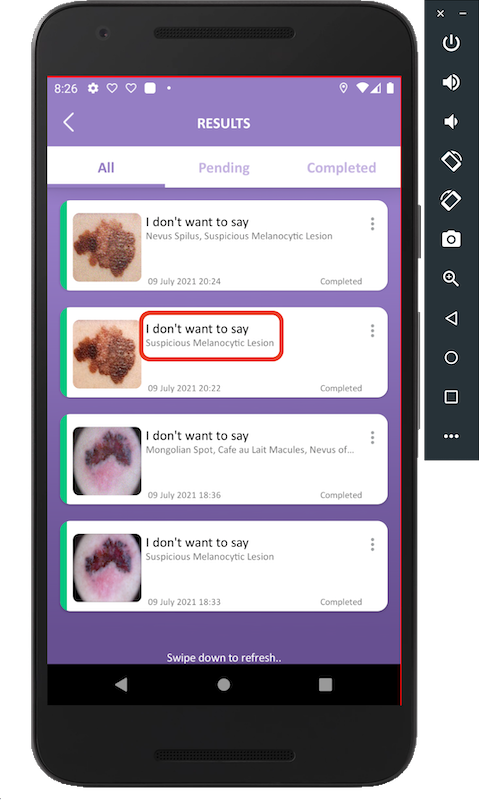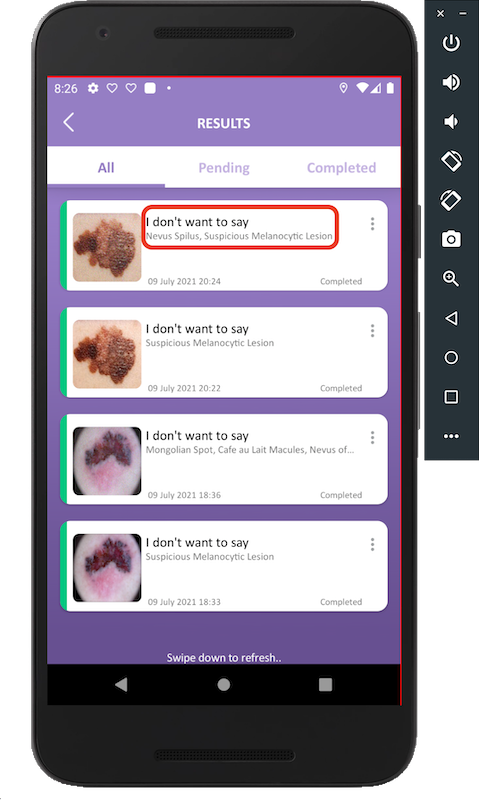

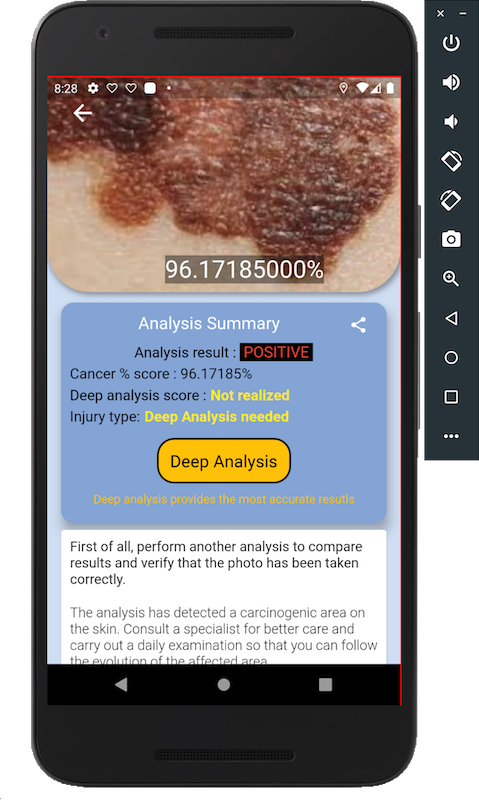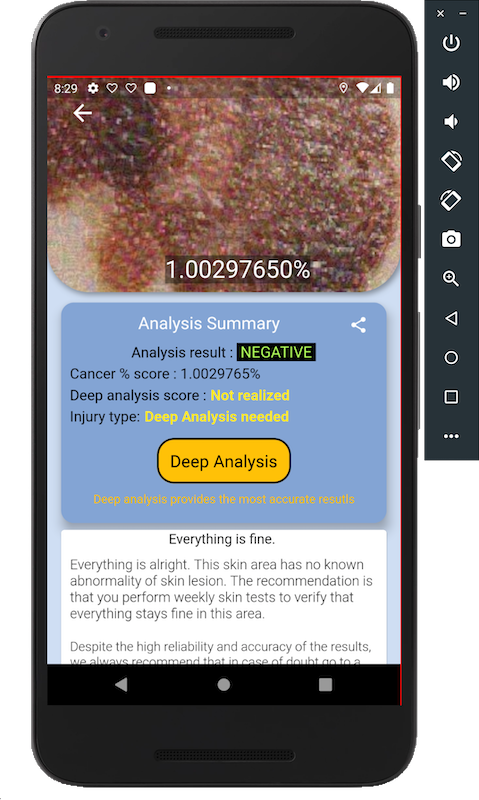

## Conclusion
In this notebook we have demonstrated how we can apply the ART library to generate adversarial images with the Fast Gradient Method and test our black-box attacks on real-world melanoma's detection apps. We've seen that even when we have no idea how is the model that runs on the app, we can create our model with a different architecture, generate and adversarial on it, and it could (and does) potentially work on another model that tryies to solve the same problem ([transferability](https://arxiv.org/pdf/1605.07277.pdf)).